# 50.040 Natural Language Processing (Fall 2024) Homework 1

**Due 04 October 2024, 23:59PM**


### STUDENT ID: 1006011

### Name: Linus Koh Zhjie

### Students with whom you have discussed (if any):

In [32]:
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from gensim.models import Word2Vec

## Introduction
Word embeddings are dense vectors that represent words, and capable of capturing semantic and syntactic similarity, relation with other words, etc.
We have introduced two approaches in the class to learn word embeddings: **Count-based** and **Prediction-based**. 
Here we will explore both approaches. Note that we use "word embeddings" and "word vectors" interchangeably.

-------

Before we start, you need to [download](http://mattmahoney.net/dc/text8.zip) the text8 dataset. Unzip the file and then put it under the "data" folder. The text8 dataset consists of one single line of long text. Please do not change the data unless you are requested to do so.

Environment:
- Python 3.5 or above
- gensim 
- sklearn
- numpy 

## 1. Count-Based Word Embeddings

### Co-Occurrence 

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $m_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "learn and live"

Document 2: "learn not and know not"

|     *    | and | know | learn | live | not |
|----------|-----|------|-------|------|-----|
| and      | 0   | 1    | 1     | 1    | 1   |
| know     | 1   | 0    | 0     | 0    | 1   |
| learn    | 1   | 0    | 0     | 0    | 1   |
| live     | 1   | 0    | 0     | 0    | 0   |
| not      | 1   | 1    | 1     | 0    | 0   |
 

### Question 1.1 [written]:
To have a better understanding of the co-occurrence matrix, please write a matrix $M$ with fixed window of $n = 2$:

Document 1: "learn to know"

Document 2: "not learn to not know well"

***Write your answer:***

|     *    | know | learn | not | to | well |
|----------|-----|------|-------|------|-----|
| know     |   0 |   1  |   1   |   2  |  1  |
| learn    |  1  |   0  |   2   |  2   |  0  |
| not      |  1 |   2  |   0   |  2   |  1  |
| to       |  2 |   2  |   2   |   0  |  0  |
| well      |  1  |  0   |   1  |  0   |  0  |
 

### Positive Pointwise Mutual Information (PPMI)
Pointwise mutual information (PMI) is one of the most important concepts in NLP. The pointwise mutual information between a target word $w$ and a context word $c$ is defined as:
\begin{align}
\operatorname{PMI}(w, c)=\log _{2} \frac{P(w, c)}{P(w) P(c)}\notag
\end{align}
It is more common to use positive PMI (PPMI) which replaces all negative PMI values with zero. 

Given co-occurrence matrix $\mathbf M\in{\mathbb Z}^{N\times N}$ of $N$ words, $m_{ij}$ is the element of $i$ th row and $j$ th column. The PPMI matrix can be calculated as 
\begin{align}
\operatorname{PPMI}_{i j}=\max \left(\log _{2} \frac{p_{i j}}{p_{i *} p_{* j}}, 0\right)\notag
\end{align}
where 
\begin{align}
p_{i j}=\frac{m_{i j}}{\sum_{i=1}^{N} \sum_{j=1}^{N} m_{i j}} \quad p_{i *}=\frac{\sum_{j=1}^{N} m_{i j}}{\sum_{i=1}^{N} \sum_{j=1}^{N} m_{i j}} \quad p_{* j}=\frac{\sum_{i=1}^{N} m_{i j}}{\sum_{i=1}^{N} \sum_{j=1}^{N} m_{i j}}\notag
\end{align}
For the details of PMI and PPMI, please refer to https://web.stanford.edu/~jurafsky/slp3/6.pdf
### Principal Components Analysis (PCA) and Truncated Singular Value Decomposition (Truncated SVD) 
The rows (or columns) of co-occurrence matrix or PPMI matrix can be utilized as word vectors, but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run dimensionality reduction. In particular, we will first run PCA (Principal Components Analysis) to reduce the dimension. In practice, it is challenging to apply PCA to large corpora because of the memory needed to perform PCA. However, if you only want the top $k$ vector components for relatively small $k$ — known as Truncated SVD — then there are reasonably scalable techniques to compute those iteratively.

### Read Corpus

Before you start, please make sure you have downloaded the dataset "text8" in the introduction.

In [33]:
def read_corpus(file_path, size=50000):
    '''
    params:
        file_path --- str: path to your data file.
        size --- int or str: the size of the corpus
    return:
        corpus --- list[str]: list of word strings.
    '''
    with open(file_path, 'r') as f:
        text = f.read()
        if size=='all':
            corpus = text.split()
        else:
            corpus = text.split()[:size]
        return corpus

Let's have a look at the corpus

In [34]:
corpus = read_corpus(r'./data/text8')
print(corpus[0:100])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']


### Question 1.2 [code]:
Implement the function "distinct_words" that reads in "corpus" and returns distinct words that appeared in the corpus and the number of distinct words. 

Then, run the sanity check cell to check your implementation.

In [35]:
def distinct_words(corpus):
    """ 
    Determine a list of distinct words for the corpus.
    Params:
        corpus --- list[str]: list of words in the corpus
    Return:
        corpus_words --- list[str]: list of distinct words in the corpus; sort this list with built-in python function "sorted"
        num_corpus_words --- int: number of distinct words in the corpus
    """
    ### YOUR CODE HERE
    corpus_words = sorted(list(set(corpus)))
    num_corpus_words = len(corpus_words)
    ### END OF YOUR CODE

    return corpus_words, num_corpus_words

In [36]:
# --------------------------------------------------
# Run this sanity check to check your implementation
# --------------------------------------------------

# Define toy corpus
test_corpus = "learn and live".split() + "learn not and know not".split()
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set(['learn','and','live','not','know'])))
ans_num_corpus_words = len(ans_test_corpus_words)

assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3 [code]: 
Implement "compute_word_matrix" that reads in "corpus" and "window_size", and returns a co-occurrence matrix, PPMI matrix and a word-to-index dictionary.

Then, run the sanity check cell to check your implementation.

In [37]:
def compute_word_matrix(corpus, window_size=1):
    """ 
    Compute co-occurrence matrix and PPMI matrix for the given corpus and window_size (default of 1).
    
    Params:
        corpus --- list[str]: list of words
        window_size --- int: size of context window
    Return:
        CoM --- numpy array of shape (num_words, num_words): 
                Co-occurrence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words 
                given by the distinct_words function.
        PPMI--- numpy array of shape (num_words, num_words): 
                PPMI matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words 
                given by the distinct_words function.
                
              
        word2Ind --- dict: dictionary that maps word to index (i.e. row/column number) for matrix CoM which is the same as PPMI.
    """
    words, num_words = distinct_words(corpus)
    CoM = None
    PPMI = None
    word2Ind = {}
    
    ### YOUR CODE HERE
    CoM = np.zeros((num_words, num_words))
    PPMI = np.zeros((num_words, num_words))
    word2Ind = dict(zip(words, range(num_words)))
    
    for i,w in enumerate(corpus):
        left_boudary = max(i-window_size, 0)
        right_boundary = min(i+window_size+1, len(corpus)) 
        context_words = corpus[left_boudary:i] + corpus[i+1:right_boundary]
        center_word = corpus[i]
        center_idx = word2Ind[center_word]
        for outside_word in context_words:
            outside_idx = word2Ind[outside_word]
            CoM[outside_idx, center_idx] += 1
            
    CoM_column = np.sum(CoM,axis=1)
    CoM_row = np.sum(CoM,axis=0)
    CoM_sum = np.sum(CoM)
    for i in range(num_words):
        for j in range(num_words):
            p_ij = CoM[i,j]/CoM_sum
            p_i = CoM_column[i]/CoM_sum
            p_j = CoM_row[j]/CoM_sum
            if p_ij == 0:
                PPMI[i,j] = 0
            else:
                PPMI[i,j] = max(math.log(p_ij/(p_i*p_j),2),0) 
        
    ### END OF YOUR CODE   
    return CoM,PPMI,word2Ind

In [38]:
# ---------------------
# Run this sanity check
# ---------------------

# Define toy corpus and get co-occurrence matrix
test_corpus = "learn not and know not".split()
CoM_test, PPMI_test, word2Ind_test = compute_word_matrix(test_corpus, window_size=1)
# Correct M and word2Ind
CoM_test_ans = np.array( 
    [[0., 1., 0., 1.],
     [1., 0., 0., 1.],
     [0., 0., 0., 1.],
     [1., 1., 1., 0.]])

PPMI_test_ans = np.array(
    [[0., 1., 0., math.log(4/3,2)],
     [1., 0., 0., math.log(4/3,2)],   
     [0., 0., 0., math.log(8/3,2)],   
     [math.log(4/3,2), math.log(4/3,2), math.log(8/3,2), 0.]])

word2Ind_ans = {'and':0, 'know':1, 'learn':2,  'not':3}

# check correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# check correct CoM shape
assert (CoM_test.shape == CoM_test_ans.shape), "CoM matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(CoM_test.shape, CoM_test_ans.shape)

# check correct PPMI shape
assert (PPMI_test.shape == PPMI_test_ans.shape), "PPMI matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(PPMI_test.shape, PPMI_test_ans.shape)
# Test correct CoM and PPMI values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student1 = CoM_test[idx1, idx2]
        correct1 = CoM_test_ans[idx1, idx2]
        student2 = PPMI_test[idx1, idx2]
        correct2 = PPMI_test_ans[idx1, idx2]
        if student1 != correct1:
            print("Correct CoM:")
            print(CoM_test_ans)
            print("Your CoM: ")
            print(CoM_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix CoM. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student1, correct1))
        if student2 != correct2:
            print("Correct PPMI:")
            print(PPMI_test_ans)
            print("Your PPMI: ")
            print(PPMI_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix PPMI. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student2, correct2))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4 [code]:
Implement "dimension_reduction" function below with python package sklearn.decomposition. For the use of PCA function and TruncatedSVD function, please refer to https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition

Then, run the sanity check cell to check your implementation.

In [39]:
def dimension_reduction (X, k=2):
    '''
    params:
        X --- numpy array of shape (num_words, word_embedding_size)
        k --- int: the number of principal components that we keep
    return:
        X_reduced --- numpy array of shape (num_words, k)
                      Using TruncatedSVD algorithm when k <= floor(word_embedding_size/10)
                      Using PCA algorithm when k > floor(word_embedding_size/10)
    '''
    X_reduced = None
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    ### YOUR CODE HERE 
    word_embedding_size = X.shape[1]
    if k <= math.floor(word_embedding_size/10):
        svd = TruncatedSVD(n_components=k, n_iter=n_iters)
        X_reduced = svd.fit_transform(X) 
    else:
        pca = PCA(n_components=k)
        X_reduced = pca.fit_transform(X)
    ### END OF YOUR CODE
    return X_reduced

In [40]:
# ---------------------
# Run this sanity check
# only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = "learn not and know not".split()
CoM_test, PPMI_test, word2Ind_test = compute_word_matrix(test_corpus, window_size=1)
CoM_test_reduced = dimension_reduction(CoM_test, k=2)

# Test proper dimensions
assert (CoM_test_reduced.shape[0] == 4), "CoM_reduced has {} rows; should have {}".format(CoM_test_reduced.shape[0], 4)
assert (CoM_test_reduced.shape[1] == 2), "CoM_reduced has {} columns; should have {}".format(CoM_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.5 [code]:
Implement "plot_embeddings" function to visualize the word embeddings on a 2-D plane. 

Then, run the sanity check cell to check your implementation.

In [41]:
def plot_embeddings(X_reduced, word2Ind, words, fig_size, fig_title):
    """ 
    Plot in a scatterplot the embeddings of the words specified in the list "words".
        
    params:
        X_reduced --- numpy array of shape (num_words , 2): numpy array of 2-d word embeddings
        word2Ind --- dict: dictionary that maps words to indices
        words --- list[str]: a list of words of which the embeddings we want to visualize
        fig_size --- tuple (a,b) : the size of figure
        fig_title --- str: title of the figure
    return:
        None
    """
    plt.figure(figsize = fig_size)
    ### YOUR CODE HERE 
    for word in words:
        idx = word2Ind[word]
        embedding = X_reduced[idx]
        x = embedding[0]
        y = embedding[1]
        
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=12)
        plt.title(fig_title)

    ### END OF YOUR CODE

--------------------------------------------------------------------------------
Outputted Plot:
--------------------------------------------------------------------------------


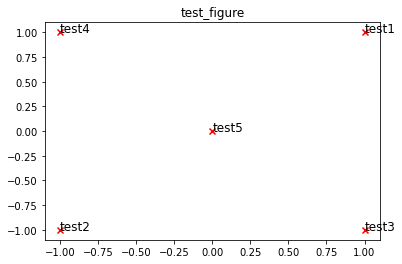

In [42]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

X_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(X_test, word2Ind_plot_test, words, (6,4), 'test_figure')

print ("-" * 80)

##### <font color=red>**Test Plot Solution**</font>
<br>
<img src="test_plot.png" width=40% style="float: left;"> </img>

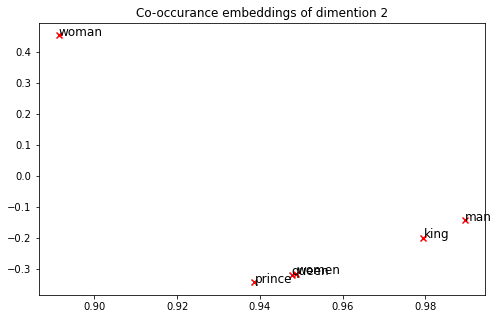

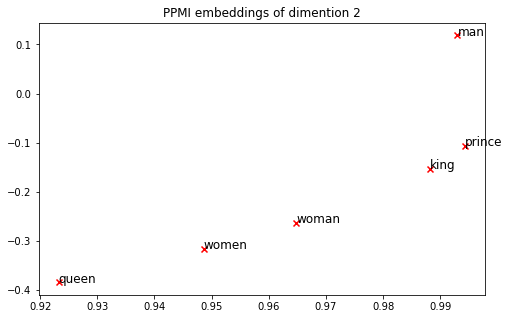

In [43]:
# -----------------------------
# Run This Cell to Produce Your Plot
# window_size is 3
# ------------------------------

corpus = read_corpus(r'./data/text8',50000)

CoM, PPMI, word2Ind = compute_word_matrix(corpus, window_size=3)
CoM_reduced = dimension_reduction(CoM, k=2)
PPMI_reduced = dimension_reduction(PPMI, k=2)

# Rescale (normalize) the rows to make them each of unit-length
CoM_lengths = np.linalg.norm(CoM_reduced, axis=1)
CoM_normalized = CoM_reduced / CoM_lengths[:, np.newaxis] # broadcasting
PPMI_lengths = np.linalg.norm(PPMI_reduced, axis=1)
PPMI_normalized = PPMI_reduced / PPMI_lengths[:, np.newaxis] # broadcasting


words = ['king','man','woman','women','queen','prince']
plot_embeddings(CoM_normalized, word2Ind, words, (8,5), 'Co-occurance embeddings of dimention 2')
plot_embeddings(PPMI_normalized, word2Ind, words, (8,5), 'PPMI embeddings of dimention 2')


## 2. Prediction-Based Word Embeddings
### Word2vec
Word2vec is a software package that contains two algorithms named CBOW and skip-gram ([Mikolov 2013](https://arxiv.org/pdf/1301.3781.pdf)). In the CBOW architecture, the model predicts the current word from a window of surrounding context words. In the continuous skip-gram architecture, the model uses the current word to predict the surrounding window of context words. The architectures are shown as follows:
<br>
<img src="Word2vec.png" width=60% style="float: left;"> </img>

### Question 2.1 [code]:
Complete the code in the function *create_word_batch*, which can be used to divide a single sequence of words into batches of words. 

For example, the word sequence ["I", "like", "NLP", "So", "does", "he"] can be divided into two batches, ["I", "like", "NLP"], ["So", "does", "he"], each with batch_size=3 words. It is more efficient to train word embedding on batches of word sequences rather than on a long single sequence. 

Then, run the sanity check cell to check your implementation.

In [44]:
def create_word_batch(words, batch_size=100):
    '''
    Split the words into batches
    params:
        words --- list[str]: a list of words
        batch_size --- int: the number of words in a batch
    return:
        batch_words: list[list[str]]batches of words, list
    '''
    batch_words = []
    
    ### YOUR CODE HERE
    batch_num = int(len(words)/batch_size)
    for i in range(batch_num):
        start = i*batch_size
        end = (i+1) * batch_size
        batch_words.append(words[start:end])
    if words[end:]:
        batch_words.append(words[end:])
    ### END OF YOUR CODE
    return batch_words

In [45]:
# --------------------------------------------------
# Run this sanity check to check your implementation
# --------------------------------------------------
words_test = ["I", "like", "NLP", "So", "does", "he"]
batch_size_test = 3

ans = [["I", "like", "NLP"],["So", "does", "he"]]

batch_words_test = create_word_batch(words_test,batch_size_test)

assert ans == batch_words_test, 'your output does not match "ans"'
print('passed!')

passed!


### Question 2.2 [code]:
Use "Word2Vec" function to build a word2vec model. For the use of "Word2Vec" function, please ,refer to https://radimrehurek.com/gensim_3.8.3/models/word2vec.html. Please use the parameters we have set for you.

It may take a few minutes to train the model.

In [46]:
whole_corpus = corpus = read_corpus(r'./data/text8', 'all')
batch_words = create_word_batch(whole_corpus)

vector_size = 100
min_count = 2
window = 3
sg = 1  #skip-gram algorithm
### YOUR CODE HERE 
#model = Word2Vec(batch_words, vector_size=100, sg=1, min_count=2, window=3, workers=3)
model = Word2Vec(sentences=batch_words, vector_size=100, window=3, min_count=2, workers=3,sg=1)
### END OF YOUR CODE
print('Done!')

Done!


In [47]:
print(len(batch_words))

170053


### Question 2.3 [code]:
Implement "get_word2Ind" function below first. Then, run the sanity check cell to check your implementation.

Use "get_word2Ind", "dimension_reduction", and "plot_embeddings" functions to visualize the word embeddings of the first 300 words in the vocabulary. 

In [48]:
def get_word2Ind(index2word):
    '''
    construct a dictionary that maps words to its index
    
    params:
        index2word --- list[str]: list of words
    return 
        word2index --- dict: keys are words, values are the corresponding indices
    '''
    word2index = dict()
    ### YOUR CODE HERE
    word2index = {token: token_index for token_index, token in enumerate(index2word)} 
    ### END OF YOUR CODE
    return word2index

In [49]:
# --------------------------------------------------
# Run this sanity check to check your implementation
# --------------------------------------------------
i2w_test = ['I','love','it']
ans_test = get_word2Ind(i2w_test)

ans = {'I':0, 'love':1, 'it':2}
assert ans == ans_test, 'your output did not match the correct answer.'
print('passed!')

passed!


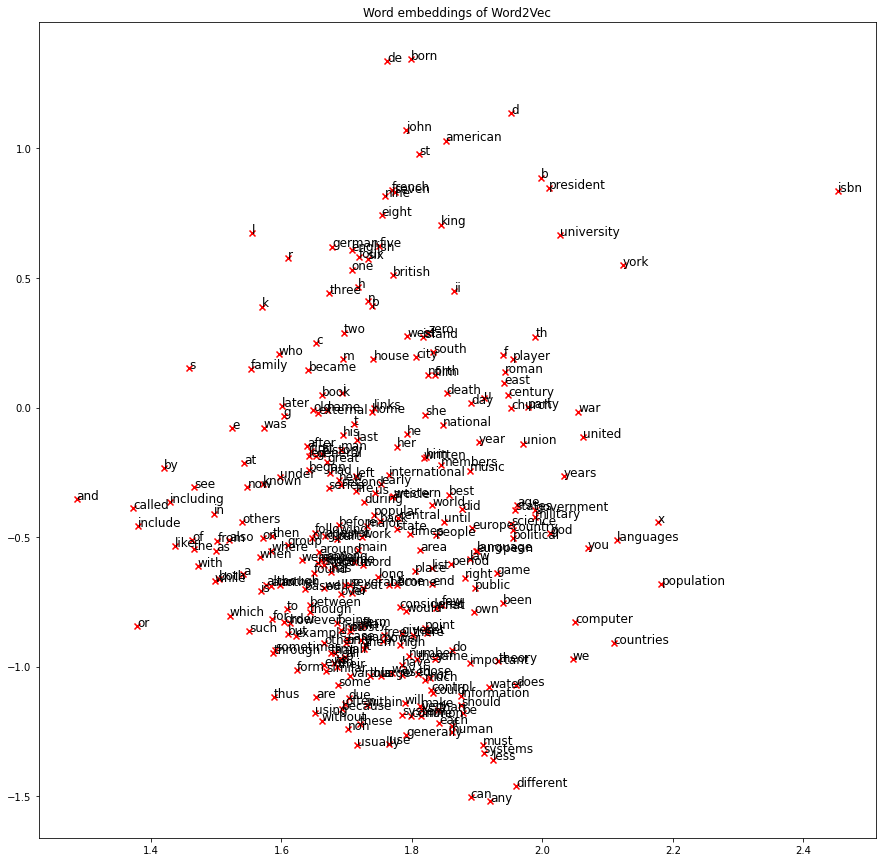

In [50]:
index2word = model.wv.index_to_key
words_to_visualize = index2word[:300]

### YOUR CODE HERE
word2Ind = get_word2Ind(index2word)
vec_reduce = dimension_reduction(model.wv.vectors, 2)
plot_embeddings(vec_reduce, word2Ind, words_to_visualize, (15,15), 'Word embeddings of Word2Vec')
### END OF YOUR CODE

### Question 2.4 [code]:
1. Find the most similar words for the given words "dog","car","man". You need to use "model.wv.most_similar" function.
2. Find out which word will it be for x in the pairs woman : king :: man : x? You need to use "model.wv.most_similar" function.

In [51]:
words =  ['dog', 'car', 'man'] 
### 1
### YOUR CODE HERE 
for w in words:
    print(model.wv.most_similar(positive=w,topn=5))
### END OF YOUR CODE

[('dogs', 0.7324758768081665), ('hound', 0.7230913043022156), ('cat', 0.7217650413513184), ('pig', 0.7140172719955444), ('breed', 0.7089774012565613)]
[('cars', 0.8191820383071899), ('driver', 0.7902672290802002), ('truck', 0.7762721180915833), ('motorcycle', 0.7699621915817261), ('automobile', 0.7673915028572083)]
[('woman', 0.8111076354980469), ('person', 0.7194528579711914), ('girl', 0.7134162783622742), ('stranger', 0.6996895670890808), ('lad', 0.6890828013420105)]


In [52]:
### 2
### YOUR CODE HERE 
model.wv.most_similar(positive=['man', 'king'], negative=['woman'],topn = 1)
### END OF YOUR CODE
### For students use "model.wv.most_similar(positive=['woman', 'king'], negative=['man'],topn = 1)", I also gave the points.
### This question "man : king :: woman : x" will be more reasonable.

[('macedon', 0.659864604473114)]

### Question 2.5 [code+written]:

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Use the `most_similar` function to find two cases where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [53]:
### This is an example for reference only 
### YOUR CODE HERE 
ex1 = model.wv.most_similar(positive=['woman', 'doctor'], negative=['man'],topn = 5)
ex2 = model.wv.most_similar(positive=['woman', 'profession'],negative=['man'],topn = 5)
print(ex1)
print(ex2)
### END OF YOUR CODE

[('nurse', 0.6223458647727966), ('faustus', 0.593644917011261), ('surgeon', 0.5680830478668213), ('dominatrix', 0.5676418542861938), ('psychiatrist', 0.5668863654136658)]
[('marriage', 0.6791006326675415), ('barrister', 0.6695377826690674), ('midwifery', 0.6691328287124634), ('quaker', 0.6643852591514587), ('polygamy', 0.6610820889472961)]


***Write your explanation:***
example 1: if we change the “man” aspect in “doctor” to “woman” aspect, it gives “nurse”. This
shows the bias that “docter” is believed to be a “male” job and “nurse” is believed as a “femaile”
job, even if “nurse” are gender-neutral. This is probability because “doctor” appears in the context
of “man” more, and “nurse” appears in the context of “woman” more in the corpus.
example 2: if we change the “man” aspect in “profession” to “woman” aspect, it gives “marriage”.
This shows the bias that “marriage” is believed to be the “profession” of “woman”, even if “profession” and “marriage” are gender-neutral. This is probability because “profession” appears in the
context of “man” more, and “marriage” appears in the context of “woman” more in the corpus.
The reason for such biases: The neutral terms acquire stereotype and bias due to the context in
which they are present in the corpus.